In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [85]:
caller = 'activation' #outrider_overexpressed/outrider_underexpressed/activation

In [86]:
input_dir = '/s/project/mll/sergey/effect_prediction/promoter_mutations/res/'

In [95]:
confounders = False

In [96]:
output_dir = input_dir + 'figures/conf_' + str(confounders).lower()

In [97]:
!mkdir -p {output_dir}

In [98]:
all_mutations_df = pd.read_csv(input_dir + caller + '.csv')
most_sign_mutations_df = pd.read_csv(input_dir + caller + '_most_significant.csv')

most_sign_mutations_df['selection'] = 'At most three'
all_mutations_df['selection'] = 'All'

res_df = pd.concat([all_mutations_df,most_sign_mutations_df])

res_df = res_df[res_df.confounders==confounders]

res_df['n_mutations'] = res_df['mutations in abnomal'] + res_df['mutations in normal']

res_df.mutation = res_df.mutation.map({'promoter':'promoter\n(TSS±2Kbp)','structural':'structural',
                                      'copy_number_gain': 'copy number\ngain', 'copy_number_loss': 'copy number\nloss', 
                                      'copy_number':'copy number', 'splice_related': 'splice-related',
                                      'frameshift': 'frameshift', 'stop_gained': 'stop gained'})

res_df['sign_stars'] = res_df['p-value'].apply(lambda x: '****' if x<1e-4 else '***' 
                                               if x<1e-3 else '**' if x<1e-2 else '*' if x<5e-2 else 'ns')

res_df

,confounders,mutation,total pairs normal,total pairs abnormal,mutations in abnomal,mutations in normal,odds ratio,p-value,selection,n_mutations,sign_stars
0,False,promoter\n(TSS±2Kbp),21162576,8348,440,1098724,1.016042,7.298360e-01,All,1099164,ns
1,False,structural,20273576,8045,137,209724,1.657372,5.531982e-08,All,209861,****
2,False,splice-related,20089155,7925,17,25303,1.704608,3.701094e-02,All,25320,*
3,False,copy number\ngain,20063852,7908,0,0,1.000000,1.000000e+00,All,0,ns
4,False,copy number\nloss,20063852,7908,0,0,1.000000,1.000000e+00,All,0,ns
5,False,copy number,20063852,7908,0,0,1.000000,1.000000e+00,All,0,ns
6,False,frameshift,20068826,7914,6,4974,3.060505,1.523363e-02,All,4980,*
7,False,stop gained,20068772,7912,4,4920,2.062731,1.322425e-01,All,4924,ns
0,False,promoter\n(TSS±2Kbp),21162576,2872,162,1098724,1.091620,2.741229e-01,At most three,1098886,ns
1,False,structural,20273576,2757,47,209724,1.659185,1.266852e-03,At most three,209771,**


In [99]:
res_df.to_csv(output_dir + f'/{caller}.csv', index=None)

In [100]:
res_df = res_df[res_df.mutation!='copy number']

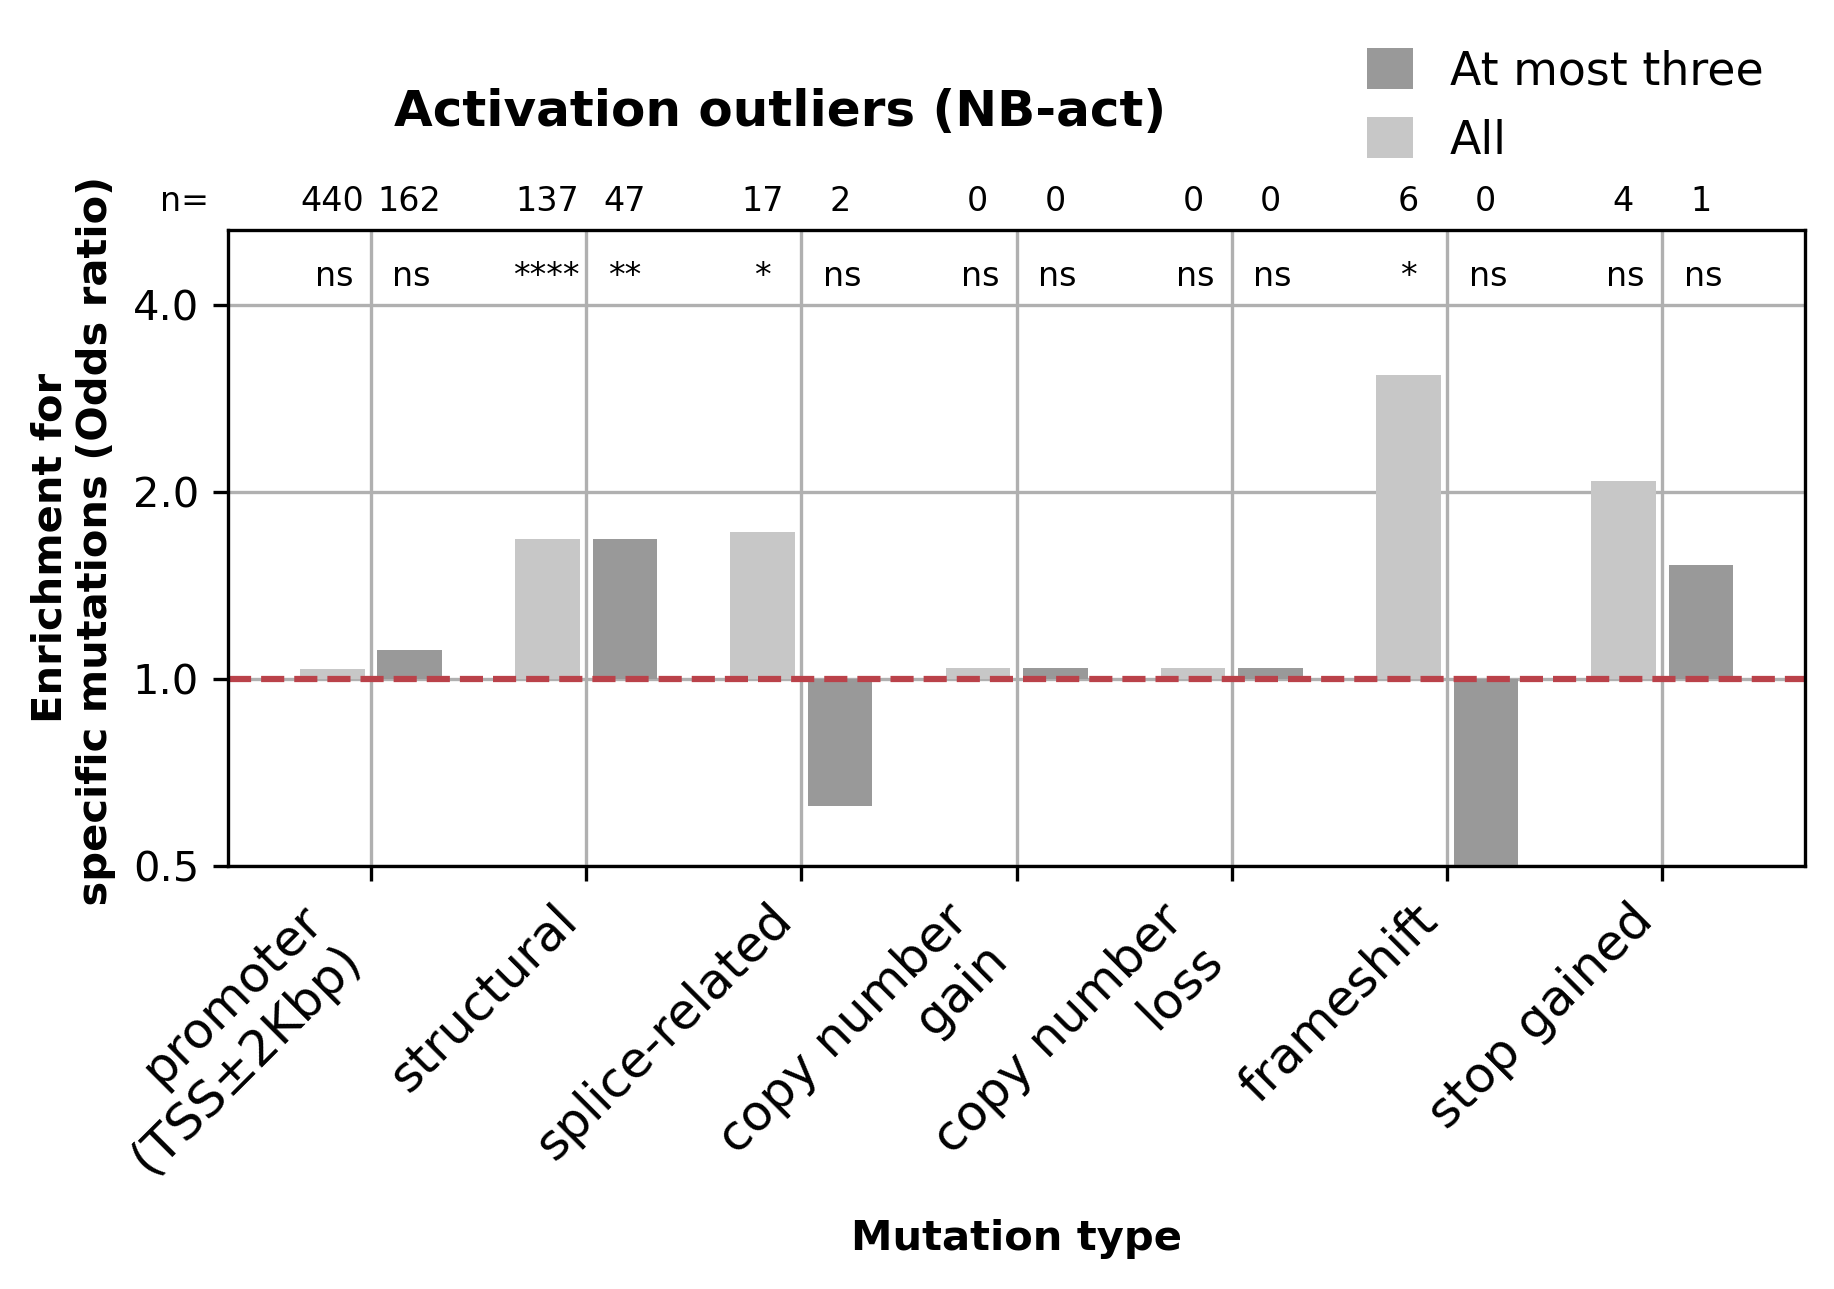

In [101]:
mutations = res_df.mutation.unique()
selection = {
    'All': res_df.loc[res_df.selection=='All', 'odds ratio'],
    'At most three': res_df.loc[res_df.selection=='At most three', 'odds ratio'],
}

x = np.arange(len(mutations))  # the label locations

threshold = 1

colors = {'All':(0.78,0.78,0.78),'At most three':(0.6,0.6,0.6)}
width = 0.3  # the width of the bars
inner_gap = 0.06

fig, ax = plt.subplots(layout='constrained', dpi=300, figsize=(6,4))

multiplier = 0

y_max_pow = np.ceil(np.log2(res_df['odds ratio'].max()))


if caller=='outrider_underexpressed':
    plot_title = 'Underexpression outliers (OUTRIDER)'
    vshift = 0
elif caller=='outrider_overexpressed':
    plot_title = 'Overexpression outliers (OUTRIDER)'
    vshift = 0
else:
    plot_title = 'Activation outliers (NB-act)'
    vshift = 0.1
    
for selection in ('All', 'At most three'):
    
    offset = (width+inner_gap) * multiplier
    
    measurement = res_df.loc[res_df.selection==selection, 'odds ratio']
        
    values = [x-threshold+0.02 if x>threshold else threshold-x-0.04 for x in measurement]
    bottom = [threshold if x>threshold else x+0.04 for x in measurement]
 
    rects = ax.bar(x + offset, values, width, bottom=bottom, label=selection, color=colors[selection])
    
    for text_idx, text in enumerate(res_df[res_df.selection==selection].sign_stars):
        ax.text(y=2**(y_max_pow+vshift), x=text_idx + offset - len(text)*0.04, s = text, fontsize=8)
        
    for text_idx, n_mut in enumerate(res_df.loc[res_df.selection==selection,'mutations in abnomal']):   
        text = f'{n_mut/1000:.2}k' if n_mut>1000 else f'{n_mut}'
        ax.text(y=2**(y_max_pow+0.5), x=text_idx + offset - len(text)*0.05, s = text, fontsize=8)
        
    multiplier += 1
    
ax.text(y=2**(y_max_pow+0.5), x=-0.8, s = 'n=', fontsize=8)

ax.axhline(1, linestyle='--',color=(0.73,0.26,0.29))

ax.set_yscale('log', base=2)

ax.set_title(plot_title, fontweight="bold", x=0.35, pad=25.)
ax.set_ylabel('Enrichment for\n specific mutations (Odds ratio)', fontweight="bold")
ax.set_xlabel('Mutation type', fontweight="bold")
ax.set_xticks(x + width/2 + inner_gap/2, mutations, rotation=45, ha='right',fontsize=12)

ax.set_yticks(2.**np.arange(-1, y_max_pow+1))
ax.set_yticklabels(2.**np.arange(-1, y_max_pow+1))

ax.set_ylim((2**-1,2**(y_max_pow+0.4)))

ax.grid()
ax.set_axisbelow(True)

handles, labels = ax.get_legend_handles_labels()

ax.legend(handles[::-1], labels[::-1],loc='upper right', 
          handlelength=1, handleheight=1,
          bbox_to_anchor=(1., 1.35), fontsize=11,  frameon=False)

plt.show()


In [102]:
fig.savefig(output_dir + f'/{caller}.png')